In [47]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import *

In [48]:
df = pd.read_csv("./DATA/Epilepsy/data.csv")

In [49]:
num_columns = len(df.columns)
print(len(df.index), num_columns)

11500 180


In [50]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def Oversample(data, labels):
    zeros = []
    ones = []
    for (index, label) in enumerate(labels):
        if label == 0:
            zeros.append(data[index])
        else:
            ones.append(data[index])

    zeros, ones = np.array(zeros), np.array(ones)
    ids = np.arange(len(ones))
    choices = np.random.choice(ids, len(zeros)) #choose entries from so that number of ones and zeroes are the same 

    res_ones_features = ones[choices]
    res_ones_labels = np.ones(len(res_ones_features))

    resampled_features = np.concatenate([res_ones_features, zeros], axis=0)
    resampled_labels = np.concatenate([res_ones_labels, np.zeros(len(zeros))], axis=0)

    return unison_shuffled_copies(resampled_features, resampled_labels)
        

In [51]:
df.head() #each row represents one second

,xx,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [52]:
df = df.sample(frac=1) #shuffle dataset
data = df.drop(['y', 'xx'], axis=1).to_numpy()
labels = df['y'].to_numpy()

count= 0
#map labels to binary - class 1 has epilepsy only. so class 1 for yes epilepsy, 0 for no
for (i,l) in enumerate(labels):
    if l != 1:
        labels[i] = 0
        count+=1
all_labels = list(set(df['y'].unique().tolist()))
print(all_labels)
print(count)

[0, 1]
9200


In [53]:
total = len(df.index)
num_zeroes = count
num_ones = total - num_zeroes
print(num_zeroes, num_ones)
zero_weight = (1/num_zeroes)*total/2
one_weight = (1/num_ones)*total/2
class_weight = {0: zero_weight, 1: one_weight}
print(class_weight)

9200 2300
{0: 0.625, 1: 2.5}


In [54]:
# data, labels = Oversample(data, labels)

In [55]:
norm = np.linalg.norm(data)
data = data/norm

In [56]:
assert(len(data) == len(labels))
train, validate, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])
train_labels, validate_labels, test_labels = np.split(labels, [int(.6*len(labels)), int(.8*len(labels))])

In [57]:
print(train.shape, validate.shape, test.shape)

(6900, 178)(2300, 178) (2300, 178)


In [58]:
TIMESTEPS = 1
def Reshape(input):
    size, features = input.shape
    return input.reshape(size, TIMESTEPS, features)
train, validate, test = Reshape(train), Reshape(validate), Reshape(test)

In [59]:
EPOCHS = 30
BATCH_SIZE = 256
INPUT_SHAPE = (TIMESTEPS, num_columns-2)
DROPOUT = 0.2

In [60]:
def Model():
    input = layers.Input(shape=INPUT_SHAPE)
    cell = layers.LSTMCell(4, dropout=DROPOUT)
    rnn = layers.RNN(cell)(input)
    fc1 = layers.Dense(128, activation='relu')(rnn)
    output = layers.Dense(1, activation='sigmoid')(fc1)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model
model = Model()
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1, 178)]          0         
_________________________________________________________________
rnn_3 (RNN)                  (None, 4)                 2928      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 3,697
Trainable params: 3,697
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

history = model.fit(train, train_labels, 
epochs=EPOCHS, 
validation_data=(validate, validate_labels), 
batch_size=BATCH_SIZE, 
verbose=2, 
callbacks=[callback],
class_weight=class_weight,
shuffle=True)

Epoch 1/30
27/27 - 0s - loss: 0.7223 - accuracy: 0.4400 - val_loss: 0.8671 - val_accuracy: 0.4339
Epoch 2/30
27/27 - 0s - loss: 0.7223 - accuracy: 0.4426 - val_loss: 0.8671 - val_accuracy: 0.4343
Epoch 3/30
27/27 - 0s - loss: 0.7223 - accuracy: 0.4574 - val_loss: 0.8671 - val_accuracy: 0.4357
Epoch 4/30
27/27 - 0s - loss: 0.7223 - accuracy: 0.4454 - val_loss: 0.8671 - val_accuracy: 0.4361
Epoch 5/30
27/27 - 0s - loss: 0.7223 - accuracy: 0.4517 - val_loss: 0.8671 - val_accuracy: 0.4374
Epoch 6/30
27/27 - 0s - loss: 0.7223 - accuracy: 0.4439 - val_loss: 0.8671 - val_accuracy: 0.4387
Epoch 7/30
27/27 - 0s - loss: 0.7223 - accuracy: 0.4462 - val_loss: 0.8671 - val_accuracy: 0.4409
Epoch 8/30
27/27 - 0s - loss: 0.7223 - accuracy: 0.4417 - val_loss: 0.8671 - val_accuracy: 0.4409


In [63]:
# model.save("./Models/Epilepsy_LSTM1.h5")

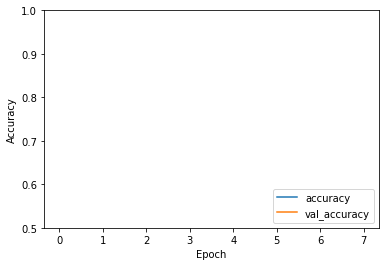

In [64]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [65]:
test_loss, test_acc = model.evaluate(test,  test_labels, verbose=2)

72/72 - 0s - loss: 0.8765 - accuracy: 0.4500


In [66]:
test_labels[:50]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [67]:
# prediction = model.predict(np.expand_dims(test[0], axis=0))
prediction = model.predict(test)
print(prediction.shape)
for p in prediction[:50]:
    print(p)
    # print(np.argmax(prediction))

(2300, 1)
[0.5000018]
[0.50000703]
[0.50000465]
[0.50000554]
[0.50000215]
[0.49999562]
[0.49999943]
[0.50000393]
[0.5000034]
[0.5000018]
[0.5]
[0.5000142]
[0.5000093]
[0.49999762]
[0.5000038]
[0.50000143]
[0.49999967]
[0.5000015]
[0.5000017]
[0.49999845]
[0.49999064]
[0.499997]
[0.49999875]
[0.50000197]
[0.49999848]
[0.5000009]
[0.4999999]
[0.49999434]
[0.49999866]
[0.49999666]
[0.49999994]
[0.50000167]
[0.5000085]
[0.5000017]
[0.49999964]
[0.50000983]
[0.50000155]
[0.49999914]
[0.5000101]
[0.49999958]
[0.5000007]
[0.5000048]
[0.4999887]
[0.5000028]
[0.50000477]
[0.50000066]
[0.5000011]
[0.49999955]
[0.49999505]
[0.5000027]
